Author: Samantha Butler

In [1]:
# USAGE
# python region_proposal_detection.py --image beagle.png

# import the necessary packages
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from imutils.object_detection import non_max_suppression

import numpy as np
import argparse
import cv2

import matplotlib.pyplot as plt

try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

<h1>Selective Search </h1>
<h3>PART A</h3>

In [2]:
# Example execution
args = dict()
args['image'] = 'beagle.png'
args['method'] = 'fast'   # Other choice is quality
args['conf'] = 0.9
args['filter'] = None

In [3]:
def sliding_window(image, stepSize, windowSize=[128,128]):
	# slide a window across the width of the image
	for y in range(0, image.shape[0], stepSize):
        # slide a window across the height of the image
		for x in range(0, image.shape[1], stepSize):
			# yield the current window (yield )
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

def selective_search_using_sliding_window(image, imageInputSize, stepSize, windowSize, minRegionPercent):
    proposals = []
    boxes = []
    
    # loop over the region proposal bounding box coordinates generated by
    # running selective search
    for (x, y, origROI) in sliding_window(image, stepSize, windowSize):
        # if the width or height of the sliding window region is less than 10% of the
        # image width or height, ignore it (i.e., filter out small
        # objects that are likely false-positives)
        if windowSize[0] / float(W) < (minRegionPercent/100) or windowSize[1] / float(H) < (minRegionPercent/100):
            continue

        # extract the region from the input image, convert it from BGR to
        # RGB channel ordering, and then resize it to 224x224 (the input
        # dimensions required by our pre-trained CNN)
        roi = image[y:y + windowSize[1], x:x + windowSize[0]]
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        roi = cv2.resize(roi, imageInputSize)

        # further preprocess by the ROI
        roi = img_to_array(roi)
        roi = preprocess_input(roi)

        # update our proposals and bounding boxes lists
        proposals.append(roi)
        boxes.append((x, y, windowSize[0], windowSize[1]))

    # convert the proposals list into NumPy array and show its dimensions
    proposals = np.array(proposals)
    print("[INFO] proposal shape: {}".format(proposals.shape))
    print("[INFO] {} regions found by selective search".format(len(boxes)))
    return proposals,boxes

In [4]:
def labels_and_preds(labelFilters, proposals, top=1):
    # if the label filter is not empty, break it into a list
    if labelFilters is not None:
        labelFilters = labelFilters.lower().split(",")

    # load ResNet from disk (with weights pre-trained on ImageNet)
    print("[INFO] loading ResNet...")
    model = ResNet50(weights="imagenet")
    
    # classify each of the proposal ROIs using ResNet and then decode the
    # predictions
    print("[INFO] classifying proposals...")
    preds = model.predict(proposals)
    preds = imagenet_utils.decode_predictions(preds, top=top)
    return preds

# initialize a dictionary which maps class labels (keys) to any
# bounding box associated with that label (values)
def classes_to_bounding_boxes(preds, boxes, labelFilters, confidence):
    labels = {}
    # loop over the predictions
    for (i, p) in enumerate(preds):
        # grab the prediction information for the current region proposal
        (imagenetID, label, prob) = p[0]
        print (label)

        # only if the label filters are not empty *and* the label does not
        # exist in the list, then ignore it
        if labelFilters is not None and label not in labelFilters:
            continue

        # filter out weak detections by ensuring the predicted probability
        # is greater than the minimum probability
        if prob >= confidence:
            # grab the bounding box associated with the prediction and
            # convert the coordinates
            (x, y, w, h) = boxes[i]
            box = (x, y, x + w, y + h)

            # grab the list of predictions for the label and add the
            # bounding box + probability to the list
            L = labels.get(label, [])
            L.append((box, prob))
            labels[label] = L
#         print('boxes: ',len(boxes))
        
    return labels

In [30]:
def final_results(image, labels):
    reg_proposals = {}
    proposals_image = image.copy()
    annotated_image = image.copy()

    # loop over the labels for each of detected objects in the image
    for label in labels.keys():
#         print(label)
        # clone the original image so that we can draw on it
#         print("[INFO] showing results for '{}'".format(label))

        # loop over all bounding boxes for the current label
        for (box, prob) in labels[label]:
            # draw the bounding box on the image
            (startX, startY, endX, endY) = box
            cv2.rectangle(proposals_image, (startX, startY), (endX, endY),
                (0, 255, 0), 2)

        # extract the bounding boxes and associated prediction
        # probabilities, then apply non-maxima suppression
        boxes = np.array([p[0] for p in labels[label]])
#         print(label,labels[label][0][0],labels[label][0][1])
#         print('label: ', label, 'before suppression boxes: ', len(boxes))
        reg_proposals['beforeNMS'] = len(boxes)
#         reg_proposals['p[0]'] = p[0]
        proba = np.array([p[1] for p in labels[label]])
#         print(labels,proba)
        boxes = non_max_suppression(boxes, proba)
        reg_proposals['afterNMS'] = len(boxes)
        reg_proposals[label] = labels[label]
#         reg_proposals['p[1]'] = p[1]
#         print('label: ', label, 'after suppression boxes: ', len(boxes))
        
        # loop over all bounding boxes that were kept after applying
        # non-maxima suppression
        for (startX, startY, endX, endY) in boxes:
            # draw the bounding box and label on the image
            cv2.rectangle(annotated_image, (startX, startY), (endX, endY),
                (0, 255, 0), 2)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.putText(annotated_image, label, (startX, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 1)
            
#     print(reg_proposals)
    return proposals_image, annotated_image, reg_proposals

In [6]:
image = cv2.imread(args['image'])
(H, W) = image.shape[:2]
imageSize = (224,224) # Needed for Resnet50
stepSizes = 8 # The smaller the sliding window the more computational power the algorithm will take
windowSize= [128,128]
minRegionPercent = 10

proposals, boxes = selective_search_using_sliding_window(image,imageSize,stepSizes,windowSize,minRegionPercent)

[INFO] proposal shape: (2646, 224, 224, 3)
[INFO] 2646 regions found by selective search


In [7]:
labelFilters = ['beagle'] # limiting category
top = 1 # Choosing top 1 category

preds = labels_and_preds(args['filter'], proposals, top)
labels = classes_to_bounding_boxes(preds, boxes, labelFilters, 0.9)

[INFO] loading ResNet...
[INFO] classifying proposals...
Boston_bull
Boston_bull
Boston_bull
toilet_tissue
Boston_bull
toilet_tissue
Boston_bull
Boston_bull
Boston_bull
Boston_bull
Doberman
Boston_bull
Italian_greyhound
Doberman
Doberman
cowboy_hat
Doberman
Doberman
Doberman
beagle
Labrador_retriever
Walker_hound
Saint_Bernard
beagle
beagle
beagle
beagle
beagle
beagle
beagle
beagle
beagle
beagle
beagle
beagle
beagle
beagle
beagle
beagle
beagle
beagle
beagle
beagle
beagle
paper_towel
beagle
beagle
beagle
paper_towel
quill
quill
paper_towel
quill
quill
quill
quill
quill
quill
quill
quill
studio_couch
limousine
limousine
Boston_bull
Boston_bull
Boston_bull
Boston_bull
Boston_bull
Boston_bull
Boston_bull
toilet_tissue
Boston_bull
Boston_bull
Boston_bull
toilet_tissue
basenji
Doberman
cowboy_hat
Doberman
Italian_greyhound
Italian_greyhound
beagle
beagle
beagle
beagle
EntleBucher
beagle
beagle
beagle
beagle
beagle
beagle
beagle
beagle
beagle
beagle
beagle
beagle
beagle
beagle
beagle
beagle
b

{'beforeNMS': 145, 'afterNMS': 3, 'beagle': [((192, 24, 320, 152), 0.9169176), ((240, 24, 368, 152), 0.9122045), ((248, 24, 376, 152), 0.91137964), ((256, 24, 384, 152), 0.92570764), ((264, 24, 392, 152), 0.908094), ((288, 24, 416, 152), 0.9238359), ((224, 32, 352, 160), 0.9185634), ((264, 32, 392, 160), 0.9305946), ((272, 32, 400, 160), 0.9335677), ((224, 40, 352, 168), 0.94610214), ((240, 40, 368, 168), 0.90564877), ((248, 40, 376, 168), 0.9235011), ((256, 40, 384, 168), 0.95894486), ((264, 40, 392, 168), 0.96375895), ((272, 40, 400, 168), 0.95949835), ((280, 40, 408, 168), 0.9246952), ((288, 40, 416, 168), 0.9404898), ((296, 40, 424, 168), 0.9175893), ((312, 40, 440, 168), 0.9146566), ((320, 40, 448, 168), 0.9023739), ((208, 48, 336, 176), 0.9203053), ((224, 48, 352, 176), 0.9577445), ((240, 48, 368, 176), 0.920655), ((256, 48, 384, 176), 0.9449744), ((264, 48, 392, 176), 0.96312755), ((272, 48, 400, 176), 0.94303614), ((280, 48, 408, 176), 0.9087262), ((208, 56, 336, 184), 0.927102

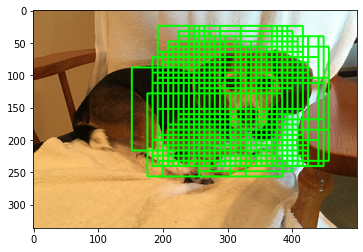

In [32]:
proposals_image, annotated_image, reg_proposals = final_results(image, labels)
print(reg_proposals)
plt.imshow(cv2.cvtColor(proposals_image, cv2.COLOR_BGR2RGB))

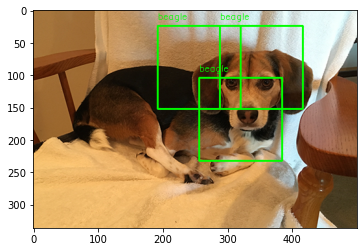

In [9]:
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))

<h3>PART B</h3>
<h4>Evaluate the window and region proposal approaches to understand count. Plot a graph for WxW=128, for S=[1,2,4,8,16,32]. The code should report the findings of how many windows per each of the 6 settings compared to the fast/quality evaluation of the region proposal system.  A test image called test.png is provided. </h4>

In [10]:
# Initial fast/quality selective search function
def selective_search_fast_quality(image, method):
    # initialize OpenCV's selective search implementation and set the
    # input image
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)

    # check to see if we are using the *fast* but *less accurate* version
    # of selective search
    if method == "fast":
        ss.switchToSelectiveSearchFast()

    # otherwise we are using the *slower* but *more accurate* version
    else:
        ss.switchToSelectiveSearchQuality()

    # run selective search on the input image
    rects = ss.process()

    # return the region proposal bounding boxes
    print("[INFO] {} regions found by selective search".format(len(rects)))
    return rects

def selective_search_fast_quality_regions(rects, imageInputSize, minRegionPercent):
    # initialize the list of region proposals that we'll be classifying
    # along with their associated bounding boxes
    proposals = []
    boxes = []

    # loop over the region proposal bounding box coordinates generated by
    # running selective search
    for (x, y, w, h) in rects:
        # if the width or height of the region is less than 10% of the
        # image width or height, ignore it (i.e., filter out small
        # objects that are likely false-positives)
        if w / float(W) < (minRegionPercent/100) or h / float(H) < (minRegionPercent/100):
            continue

        # extract the region from the input image, convert it from BGR to
        # RGB channel ordering, and then resize it to 224x224 (the input
        # dimensions required by our pre-trained CNN)
        roi = image[y:y + h, x:x + w]
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        roi = cv2.resize(roi, imageInputSize)

        # further preprocess by the ROI
        roi = img_to_array(roi)
        roi = preprocess_input(roi)

        # update our proposals and bounding boxes lists
        proposals.append(roi)
        boxes.append((x, y, w, h))

    # convert the proposals list into NumPy array and show its dimensions
    proposals = np.array(proposals)
    print("[INFO] proposal shape: {}".format(proposals.shape))
    return proposals, boxes

In [11]:
# When using sliding sizes below 4 for image test.jpg or below 2 for beagle.png it always killed
# the kernel or ran out of memory, hence why my sliding array does not start below 2 or 4.
windowsFound={}
S = [4,6,8,16,32]
args['image'] = 'test.jpg'

for slidingSize in S:
    print('\nSliding Size: ', slidingSize)
    sliding_windows_found = len(selective_search_using_sliding_window(image,imageSize,slidingSize,windowSize,minRegionPercent)[1])
#     selective_search_using_sliding_window(image,imageSize,slidingSize,windowSize,minRegionPercent)
#     print(len(selective_search_using_sliding_window(image,imageSize,slidingSize,windowSize,minRegionPercent)[1]))
    windowsFound[str(slidingSize)] = sliding_windows_found

print('\n')
fast_windows_found = len(selective_search_fast_quality(image, 'fast'))
quality_windows_found = len(selective_search_fast_quality(image, 'quality'))
print('Fast Method: ', fast_windows_found, '\n')
print('Quality Method: ', quality_windows_found, '\n')
windowsFound['fast'] = fast_windows_found
windowsFound['quality'] = quality_windows_found

print(windowsFound)


Sliding Size:  4
[INFO] proposal shape: (10500, 224, 224, 3)
[INFO] 10500 regions found by selective search

Sliding Size:  6
[INFO] proposal shape: (4704, 224, 224, 3)
[INFO] 4704 regions found by selective search

Sliding Size:  8
[INFO] proposal shape: (2646, 224, 224, 3)
[INFO] 2646 regions found by selective search

Sliding Size:  16
[INFO] proposal shape: (672, 224, 224, 3)
[INFO] 672 regions found by selective search

Sliding Size:  32
[INFO] proposal shape: (176, 224, 224, 3)
[INFO] 176 regions found by selective search


[INFO] 922 regions found by selective search
[INFO] 3633 regions found by selective search
Fast Method:  922 

Quality Method:  3633 

{'4': 10500, '6': 4704, '8': 2646, '16': 672, '32': 176, 'fast': 922, 'quality': 3633}


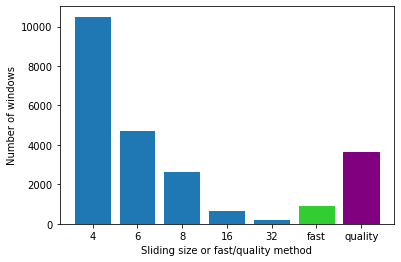

In [12]:
def graph_selective_search_methods(windowsFound):
    barlist = plt.bar(windowsFound.keys(), windowsFound.values())
    barlist[5].set_color('limegreen')
    barlist[6].set_color('purple')
    plt.ylabel('Number of windows')
    plt.xlabel('Sliding size or fast/quality method')

graph_selective_search_methods(windowsFound)

<h3>PART C</h3>
<h4>Show a graph for the number of region proposals (and then final predictions) in which the stages of use are the following (for both fast and quality)</h4>

In [13]:
fast_rects = selective_search_fast_quality(image, 'fast')
quality_rects = selective_search_fast_quality(image, 'quality')

fast_region_proposals, fast_region_boxes = selective_search_fast_quality_regions(fast_rects,(224,224),0.1)
quality_region_proposals, quality_region_boxes = selective_search_fast_quality_regions(quality_rects,(224,224),0.1)

fast_preds = labels_and_preds(args['filter'], fast_region_proposals, top)
quality_preds = labels_and_preds(args['filter'], quality_region_proposals, top)

[INFO] 922 regions found by selective search
[INFO] 3633 regions found by selective search
[INFO] proposal shape: (922, 224, 224, 3)
[INFO] proposal shape: (3633, 224, 224, 3)
[INFO] loading ResNet...
[INFO] classifying proposals...
[INFO] loading ResNet...
[INFO] classifying proposals...


In [14]:
confidence = 0.9
fast_labels = classes_to_bounding_boxes(fast_preds, fast_region_boxes, labelFilters, confidence)
quality_labels = classes_to_bounding_boxes(quality_preds, quality_region_boxes,labelFilters, confidence)

table_lamp
upright
Airedale
gong
wardrobe
shower_curtain
beagle
paintbrush
theater_curtain
Arabian_camel
gazelle
patas
bloodhound
quill
quill
kit_fox
clog
red_wolf
Sussex_spaniel
cleaver
Dandie_Dinmont
redbone
patas
red-breasted_merganser
paintbrush
English_foxhound
beagle
beagle
cleaver
Windsor_tie
wardrobe
beagle
Walker_hound
face_powder
isopod
paintbrush
polecat
spatula
beagle
broom
letter_opener
spatula
spatula
fur_coat
plane
patas
oboe
Pekinese
face_powder
Brabancon_griffon
quill
Windsor_tie
clog
beagle
gong
Windsor_tie
chiffonier
panpipe
patas
theater_curtain
cleaver
guinea_pig
Dandie_Dinmont
beagle
carton
Tibetan_terrier
Walker_hound
face_powder
face_powder
abaya
beagle
gong
ocarina
beagle
Band_Aid
English_foxhound
whippet
paintbrush
hatchet
Japanese_spaniel
Norwegian_elkhound
platypus
Walker_hound
spatula
langur
beagle
redbone
clog
gong
gibbon
frilled_lizard
face_powder
wire-haired_fox_terrier
whippet
basenji
cleaver
ice_bear
Italian_greyhound
beagle
pick
meerkat
face_powder
fa

In [21]:
fast_proposals_image, fast_annotated_image = final_results(image, fast_labels)

{'beforeNMS': 47, 'beagle': [((173, 0, 431, 284), 0.9720206), ((289, 65, 381, 197), 0.95815074), ((241, 63, 392, 228), 0.90226126), ((289, 64, 381, 199), 0.9288433), ((289, 63, 386, 197), 0.95546585), ((0, 0, 355, 220), 0.9366166), ((268, 67, 430, 275), 0.9191514), ((0, 0, 319, 237), 0.94338024), ((203, 0, 431, 284), 0.9236121), ((199, 63, 431, 242), 0.9575197), ((0, 0, 437, 336), 0.9698599), ((159, 0, 431, 284), 0.9832786), ((203, 0, 500, 336), 0.96162283), ((246, 63, 381, 214), 0.9485105), ((0, 0, 397, 336), 0.9667526), ((0, 0, 430, 336), 0.9554564), ((0, 0, 500, 336), 0.93988615), ((205, 64, 381, 242), 0.9431786), ((219, 67, 324, 178), 0.9191464), ((268, 75, 403, 275), 0.9596371), ((104, 0, 500, 295), 0.96475273), ((268, 75, 392, 237), 0.97811866), ((81, 88, 279, 270), 0.94199216), ((111, 0, 415, 289), 0.9909594), ((289, 65, 381, 199), 0.91113245), ((199, 63, 430, 275), 0.94493216), ((0, 0, 354, 219), 0.9240914), ((231, 62, 500, 336), 0.9426279), ((79, 0, 354, 268), 0.9557671), ((39

In [22]:
quality_proposals_image, quality_annotated_image = final_results(image, quality_labels)

{'beforeNMS': 214, 'beagle': [((0, 0, 430, 336), 0.9554564), ((289, 65, 381, 197), 0.95815074), ((173, 0, 431, 284), 0.9720206), ((0, 63, 387, 336), 0.9477606), ((0, 60, 414, 336), 0.93032193), ((0, 0, 500, 336), 0.93988615), ((204, 74, 311, 233), 0.9006432), ((283, 63, 385, 183), 0.9853763), ((290, 65, 381, 181), 0.96629804), ((279, 62, 430, 251), 0.9120042), ((173, 0, 431, 292), 0.9655925), ((289, 65, 381, 199), 0.91113245), ((319, 77, 500, 255), 0.94310325), ((203, 0, 431, 284), 0.9236121), ((205, 0, 500, 336), 0.9597957), ((241, 63, 381, 197), 0.96746397), ((289, 64, 381, 199), 0.9288433), ((273, 62, 431, 256), 0.91650337), ((280, 65, 381, 224), 0.94039476), ((242, 63, 432, 229), 0.90053403), ((264, 74, 424, 235), 0.9508831), ((201, 0, 399, 199), 0.95800555), ((242, 62, 430, 251), 0.9298681), ((40, 72, 311, 236), 0.9341866), ((269, 62, 430, 251), 0.9438234), ((203, 0, 431, 292), 0.93976265), ((39, 0, 355, 231), 0.950482), ((0, 147, 315, 336), 0.92423713), ((246, 0, 500, 336), 0.945

Fast Region Proposals


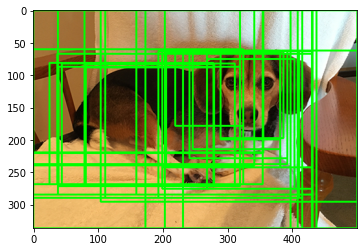

In [16]:
print('Fast Region Proposals')
plt.imshow(cv2.cvtColor(fast_proposals_image, cv2.COLOR_BGR2RGB))

Fast Annotated Region Proposal


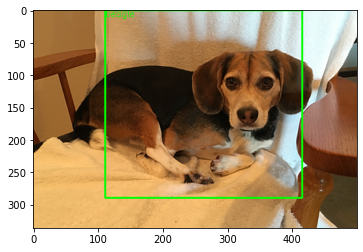

In [17]:
print('Fast Annotated Region Proposal')
plt.imshow(cv2.cvtColor(fast_annotated_image, cv2.COLOR_BGR2RGB))

Quality Region Proposals


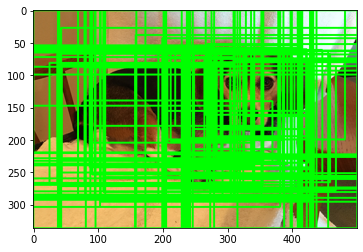

In [18]:
print('Quality Region Proposals')
plt.imshow(cv2.cvtColor(quality_proposals_image, cv2.COLOR_BGR2RGB))

Quality Annotated Region Proposal


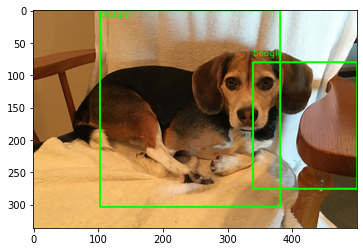

In [19]:
print('Quality Annotated Region Proposal')
plt.imshow(cv2.cvtColor(quality_annotated_image, cv2.COLOR_BGR2RGB))

<h3>PART D</h3>
<h4>Show a graph for the number of region proposals for evaluating confidence values in range .70 to .99 for fast/quality. The graph is the number of reported regions.</h4>

In [20]:
# def graph_number_regions_varying_confidence(startPoint, endPoint, stepSize):
#     for confidence in range(startPoint, endPoint, stepSize):
#          plt.plot(classes_to_bounding_boxes(fast_preds, fast_region_boxes, labelFilters, confidence), marker='',linewidth=1, alpha=0.4)
            
# graph_number_regions_varying_confidence(0.70,0.99,0.5)

TypeError: 'float' object cannot be interpreted as an integer

<h3>PART E</h3>
<h4>Before NMS, evaluate using IOU techniques, show a percentage of regions for the selective search algorithm for fast setting, that are critical according to (IOU). To be determine critical, these are regions that never overlap with any other region by more than 25%  </h4>

<h3>PART F</h3>
<h4>Plot/find the execution time for model.predict(proposals) for the fast versus quality setting of region proposals.</h4>

In [ ]:
def execution_time(method):
    e1 = cv2.getTickCount()
    selective_search_fast_quality(image, method=args["method"])
    e2 = cv2.getTickCount()

    time = (e2 - e1)/ cv2.getTickFrequency()

    return time

In [ ]:
fast_rects = selective_search_fast_quality()
quality_rects = selective_search_fast_quality()

print('Fast Execution Time: ', execution_time("fast"), 'seconds')
print('Quality Execution Time: ', execution_time("quality"), 'seconds')